In [1]:
from Stable_SSM_EM import *
import numpy as np
import pandas as pd
from dateutil import tz
from astral import Astral
from Utilities import *
from ModelTest import loadTestSets

In [2]:
colors = 2*[c["color"] for c in plt.rcParams["axes.prop_cycle"]]

## Load Feather data

In [3]:
# Info on what's available
feather_wsns = ["KTL", "GRZL"]

# Choose a network
df_feather_ktl = pd.read_csv("../raw_data/feather_data/%s.csv" % feather_wsns[0])

# Extract values
y_sd_raw = df_feather_ktl[["snowdepth_%i" % s for s in range(1, 12)]].values
y_t_raw = df_feather_ktl[["air_temp_%i" % s for s in range(1, 12)]].values
y_rh_raw = df_feather_ktl[["rel_humidity_%i" % s for s in range(1, 12)]].values
y_rad_raw = df_feather_ktl["solar_rad_8"].values
times = pd.to_datetime(df_feather_ktl["time"])

# Convert times to CA ones
utc_zone = tz.gettz("UTC")
ca_zone = tz.gettz("America/Los_Angeles")
times = np.array([t.replace(tzinfo=utc_zone).astimezone(ca_zone) for t in times])

# Get dawn/dusk times

def get_dawn_dusk(ts):
    a = Astral()
    a.solar_depression = "civil"
    city = a["Sacramento"]
    
    return np.array([city.sun(t)["sunrise"] for t in ts]), np.array([city.sun(t)["sunset"] for t in ts])

## No controls

In [41]:
n_LF = 2
sensors = [0, 1, 3, 4, 5, 6, 7, 8, 9, 10]
max_it = 100

ti, tf = 15040, 15240
Y = y_sd_raw[ti:tf, sensors].T

# Set controls
U = np.zeros([1, tf-ti])
V = np.ones([1, tf-ti]) # should be ones

# Discrete state
ss = np.zeros(tf-ti, dtype=int)
s_list = [0]

X_hat, sigma_smooth, sigma_filt, pi0, sigma0, As, Bs, Cs, Ds, Qs, Rs = ssm_em_stable(Y, U, V, ss, s_list, n_LF, max_it)

#Y_hat = np.einsum("tij,jt->it", Cs[ss], X_hat) + np.einsum("tij,jt->it", Ds[ss], V)
Y_hat = np.dot(Cs[0], X_hat) + np.dot(Ds[0], V)

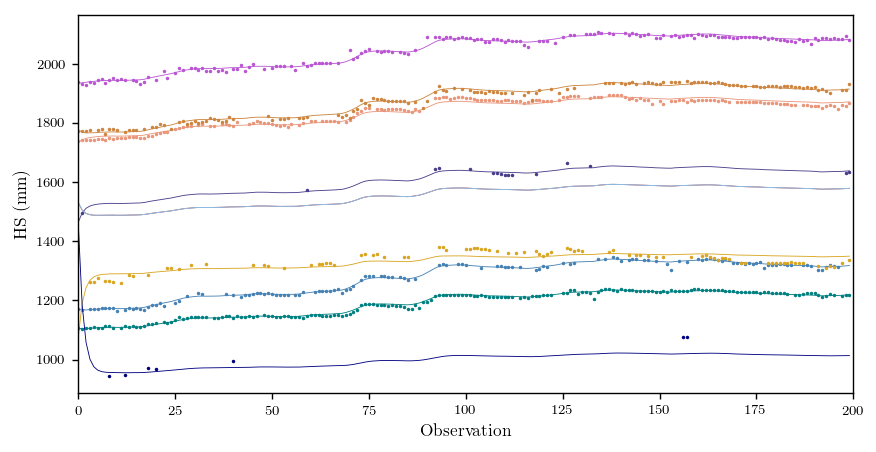

In [42]:
plt.figure(figsize=(8, 4))

for s, c in zip(range(len(sensors)), colors):
    plt.plot(Y_hat[s, :], '-', linewidth=0.5, color=c)
    plt.plot(Y[s, :], '.', markersize=2.0, color=c)

plt.xlim(0, tf-ti)
plt.xlabel("Observation")
plt.ylabel("HS (mm)")

## Using controls to de-flutter summer data
The second with index 6 exhibits very clear flutter that should be reasonably simple to handle. Let's try dealing with it first. Need to process $P_{\rm solar}$ and $T_{\rm air}$ time series first:

### Setup
HS, $P_{\rm solar}$ as observations

In [61]:
sensors = [6]

ti, tf = 29060, 30100 #29178
Y = np.vstack((y_sd_raw[ti:tf, sensors].T, y_rad_raw[ti:tf].reshape(-1, 1).T))

# Set controls
U = np.zeros([1, tf-ti])
V = np.ones([1, tf-ti]) # should be ones

# Discrete state. Convention: s_t = 1 if day, 0 if night
# ss = []

# for t in range(tf-ti):
#     # Get dawn and dusk times
#     dawn, dusk = get_dawn_dusk(times[ti+t:ti+t+1])
#     # Append 1 if it's daytime, 0 if not
#     ss.append(1 if dawn[0] < times[ti+t] < dusk[0] else 0)
    
# ss = np.array(ss, dtype=int)

# s_list = [0, 1]

ss = np.zeros(tf-ti, dtype=int)
s_list = [0]

### Run algorithm

In [62]:
n_LF = 2
max_it = 50

X_hat, sigma_smooth, sigma_filt, pi0, sigma0, As, Bs, Cs, Ds, Qs, Rs = ssm_em_stable(Y, U, V, ss, s_list, n_LF, max_it)

Y_hat = np.einsum("tij,jt->it", Cs[ss], X_hat) + np.einsum("tij,jt->it", Ds[ss], V)

([<matplotlib.axis.XTick at 0x11871db10>,
 <a list of 21 Text xticklabel objects>)

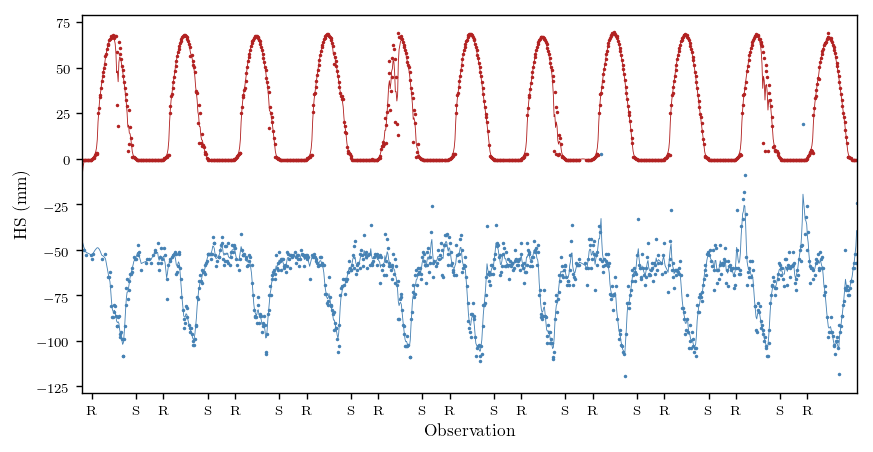

In [63]:
plt.figure(figsize=(8, 4))

for s, c in zip(range(len(sensors)*2), colors):
    plt.plot(times[ti:tf], Y_hat[s, :], '-', linewidth=0.5, color=c)
    plt.plot(times[ti:tf], Y[s, :], '.', markersize=2.0, color=c)

plt.xlim(times[ti], times[tf])
plt.xlabel("Observation")
plt.ylabel("HS (mm)")

# Tick x axis at dawn and dusk each day
dawns, dusks = get_dawn_dusk(times[ti:tf:96])
dawn_dusk_ticks = np.array(zip(dawns, dusks)).flatten()
plt.xticks(dawn_dusk_ticks[:-1], ["R", "S"] * (len(dawn_dusk_ticks) / 2))

In [15]:
print "As:\n", As
print "\nBs:\n", Bs
print "\nCs:\n", Cs
print "\nDs:\n", Ds
print "\nRs:\n", Rs

As:
[[[ 0.59511693]]

 [[ 0.98706667]]]

Bs:
[[[ -1.50503086e-02   4.86275343e+01]]

 [[  2.00378384e-02  -2.33221445e-02]]]

Cs:
[[[-0.10911978]]

 [[ 2.7154626 ]]]

Ds:
[[[-58.6678845 ]]

 [[ 62.15333765]]]

Rs:
[[[ 3.57577581]]

 [[ 0.        ]]]


([<matplotlib.axis.XTick at 0x11a82cbd0>,
 <a list of 32 Text xticklabel objects>)

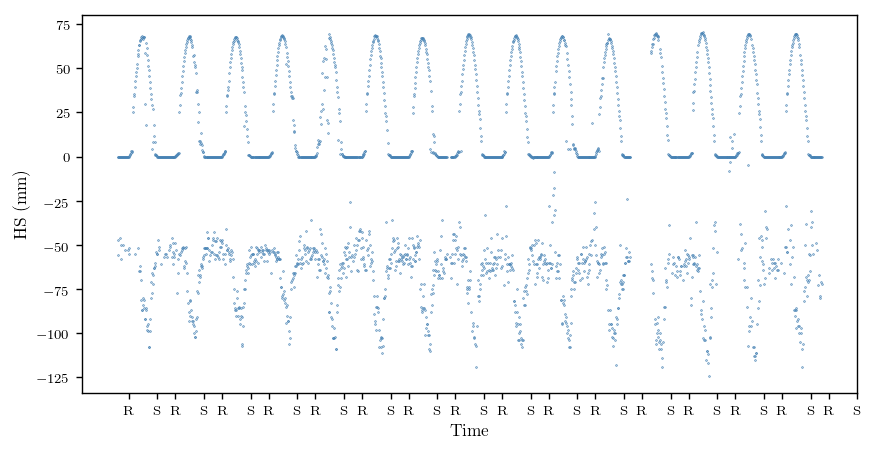

In [27]:
ti = 29050
tf = 30500

plt.figure(figsize=(8, 4))

plt.plot_date(pd.to_datetime(times[ti:tf]), y_sd_raw[ti:tf, 6], '.', markersize=0.7, color=colors[0])
plt.plot_date(pd.to_datetime(times[ti:tf]), y_rad_raw[ti:tf], '.', markersize=0.7, color=colors[0])

#plt.xlim(0, tf-ti)
plt.xlabel("Time")
plt.ylabel("HS (mm)")

# Tick x axis at dawn and dusk each day
dawns, dusks = get_dawn_dusk(times[ti:tf:96])
dawn_dusk_ticks = np.array(zip(dawns, dusks)).flatten()
plt.xticks(dawn_dusk_ticks, ["R", "S"] * (len(dawn_dusk_ticks) / 2))

## Checking PCA-only result

(0, 200)

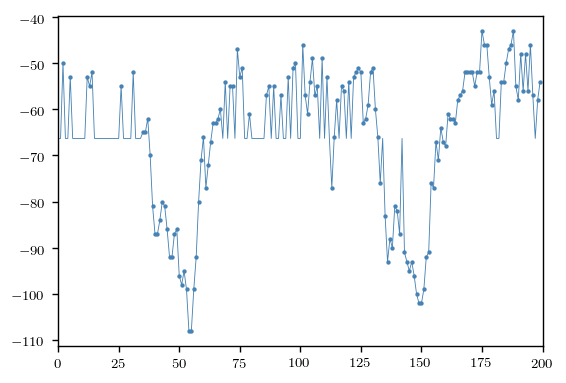

In [10]:
Y_mean = np.nanmean(Y, axis=1).reshape(-1, 1)
C, X_PCA, Y_imp = pca_est_MD(Y - Y_mean, n_LF, max_it)

for s, c in zip(range(len(sensors)), colors):
    plt.plot(Y_imp[s, :] + Y_mean[s], '-', linewidth=0.5, color=c)
    plt.plot(Y[s, :], '.', markersize=3.0, color=c)
    
plt.xlim(0, tf-ti)

In [ ]:
#ti, tf = 27005, 27500
#ti, tf = 27015, 27055 # ~ night
#ti, tf = 27065, 27105 # ~ day
ti, tf = 15005, 15205 # ~ 2 full days

plt.plot(y_sd_raw[ti:tf, :])

## Scratch work

In [ ]:
nan_sensors, nan_times = np.where(np.isnan(Y))
obs_sensors, obs_times = np.where(~np.isnan(Y))

In [ ]:
E_y = Y.copy()
E_y[nan_sensors, nan_times] = (np.dot(C, X_hat) + np.dot(D, V))[nan_sensors, nan_times]

In [ ]:
Y_residual = Y - Y_hat

In [ ]:
plt.plot(Y_residual.T)